<a href="https://colab.research.google.com/github/WDaugherty/Sepsis-Classfication/blob/Test/data_proc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

*Here we will load in the data and do any sort of the pre-processing described in any of the papers*

## Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/info5375/token.txt') as f:
    token = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/info5375
!git clone https://{YOUR_TOKEN}@github.com/WDaugherty/Sepsis-Classfication.git
%cd /content/gdrive/MyDrive/info5375/Sepsis-Classfication
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/info5375

PROJECT_ROOT = f"/content/gdrive/MyDrive/info5375/Sepsis-Classfication"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/info5375’: File exists
Cloning into 'Sepsis-Classfication'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 7), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (21/21), 5.62 KiB | 821.00 KiB/s, done.
/content/gdrive/MyDrive/info5375/Sepsis-Classfication
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 2.00 KiB | 38.00 KiB/s, done.
From https://github.com/WDaugherty/Sepsis-Classfication
   967d713..64d3665  Test       -> origin/Test
Already up to date.
/content/gdrive/MyDrive/info5375


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2


## Import code dependencies

In [8]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import librosa
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
import torchaudio.transforms as T
import torch.fft
import wfdb
print("Packages Imported")

Packages Imported


## Data Ingestion

Here we are going to load in the MIMIC/MITBIH datasets. This may require a license/approved application so we should get on this ASAP.

<br> 

Here is a resource for loading in and exploring the dataset: https://github.com/MIT-LCP/wfdb-python

In [6]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 4.1 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


In [10]:
import os
wfdb.dl_database('mitdb', os.path.join(os.getcwd(), 'mitdb'))

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

## Sample Visualization

In [33]:
#Reads the local recording
record = wfdb.rdrecord('mitdb/100', sampto=3000)
annotation = wfdb.rdann('mitdb/100', 'atr', sampto=3000)


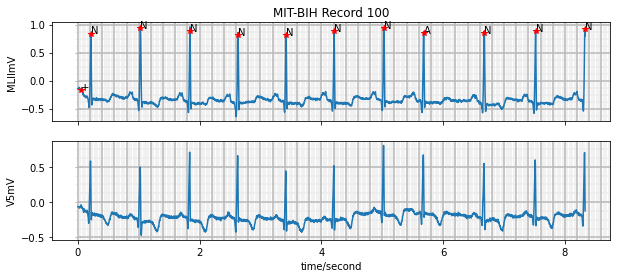

In [35]:
#Sample plot of the data 
wfdb.plot_wfdb(record=record, annotation=annotation, plot_sym=True,
                   time_units='seconds', title='MIT-BIH Record 100',
                   figsize=(10,4), ecg_grids='all')

##Filtering

In [61]:
import numpy as np
import scipy.signal as signal
import wfdb
#Low-Pass Filter
def filter_low(signal, fs, cutoff):
    """
    Applies a low-pass filter to the input ECG signal.

    Args:
    - signal (numpy array): the input ECG signal.
    - fs (float): the sampling frequency of the signal.
    - cutoff (float): the cutoff frequency of the low-pass filter.

    Returns:
    - filtered_signal (numpy array): the filtered ECG signal.
    """

    # Define filter coefficients
    b, a = signal.butter(4, cutoff / (fs / 2), 'low')

    # Apply filter to signal
    filtered_signal = signal.filtfilt(b, a, signal)

    return filtered_signal



In [41]:
#High-Pass Filter

def filter_high(signal, fs, cutoff):
    """
    Applies a high-pass filter to the input ECG signal.

    Args:
    - signal (numpy array): the input ECG signal.
    - fs (float): the sampling frequency of the signal.
    - cutoff (float): the cutoff frequency of the high-pass filter.

    Returns:
    - filtered_signal (numpy array): the filtered ECG signal.
    """

    # Define filter coefficients
    b, a = signal.butter(4, cutoff / (fs / 2), 'high')

    # Apply filter to signal
    filtered_signal = signal.filtfilt(b, a, signal)

    return filtered_signal



In [71]:
#Notch Filter

def filter_notch(signal, fs, notch_freq):
    """
    Applies a notch filter to the input ECG signal.

    Args:
    - signal (numpy array): the input ECG signal.
    - fs (float): the sampling frequency of the signal.
    - notch_freq (float): the frequency of the notch filter.

    Returns:
    - filtered_signal (numpy array): the filtered ECG signal.
    """

     # Define filter coefficients
    q = 30.0  # Q-factor
    w0 = notch_freq / (fs / 2)
    b, a = signal.iirnotch(w0, q,fs)

    # Apply filter to signal
    filtered_signal = signal.filtfilt(b, a, signal)

    return filtered_signal



In [68]:
# Load ECG signal
signal = record.p_signal
fs = record.fs
signal.shape

(3000, 2)

In [72]:
# Apply low-pass filter
cutoff = 10.0
signal_filtered = filter_low(signal, fs, cutoff)

AttributeError: ignored

In [62]:
# Apply high-pass filter
cutoff = 0.5
signal_filtered = filter_high(signal, fs, cutoff)

IndexError: ignored

In [73]:
# Apply notch filter
notch_freq = 60.0
signal_filtered = filter_notch(signal, fs,notch_freq)


AttributeError: ignored

## Baseline correction

In [ ]:
def remove_baseline_drift(signal, sampling_freq):
    # apply high-pass filter to remove baseline wander
    # set the cutoff frequency to 0.5 Hz, which is appropriate for ECG signals
    b, a = signal.butter(1, 0.5 / (sampling_freq / 2), 'highpass')
    filtered_signal = signal.filtfilt(b, a, signal)
    
    # calculate the moving median of the filtered signal
    window_size = int(sampling_freq / 2)
    median_signal = signal.medfilt(filtered_signal, window_size)
    
    # subtract the moving median from the filtered signal to remove baseline drift
    corrected_signal = filtered_signal - median_signal
    
    return corrected_signal

## Resampling

## Normalization